# Modeling

This notebook contains all steps taken in the modeling phase of the data science pipeline for the Superstore Time Series project. This notebook does rely on helper files so if you want to run the code blocks in this notebook ensure that you have all the helper files in the same directory.

---

## The Required Imports

Everything we need to run the code blocks in this notebook are imported below. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn and sklearn installed on your computer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from prophet import Prophet

from sklearn.metrics import mean_squared_error

# from prepare import split_data
from wrangle import *
from prepare import split_data
from evaluate import *
from model import *

Importing plotly failed. Interactive plots will not work.


---

## Acquire, Prepare, and Split the Data

Here we will acquire and prepare the data using the wrangle module. We'll then split each dataframe into train, validate, and test using the prepare module.

In [2]:
superstore, store_east, store_west, store_south, store_central, office_supplies, furniture, technology = wrangle_remove_outliers()

Reading from .csv file.


In [3]:
# Here we'll resample into a less finely grained period to produce a more accurate forecast.

resample_period = 'M'

# This is the periods that are used for producing the moving averages
periods = [1, 3, 6, 12]

# Year size for previous cycle
year_size = 12

superstore = superstore.resample(resample_period).sum()

store_east = store_east.resample(resample_period).sum()
store_west = store_west.resample(resample_period).sum()
store_south = store_south.resample(resample_period).sum()
store_central = store_central.resample(resample_period).sum()

office_supplies = office_supplies.resample(resample_period).sum()
furniture = furniture.resample(resample_period).sum()
technology = technology.resample(resample_period).sum()

In [4]:
superstore_train, superstore_validate, superstore_test = split_data(superstore)

store_east_train, store_east_validate, store_east_test = split_data(store_east)
store_west_train, store_west_validate, store_west_test = split_data(store_west)
store_south_train, store_south_validate, store_south_test = split_data(store_south)
store_central_train, store_central_validate, store_central_test = split_data(store_central)

office_supplies_train, office_supplies_validate, office_supplies_test = split_data(office_supplies)
furniture_train, furniture_validate, furniture_test = split_data(furniture)
technology_train, technology_validate, technology_test = split_data(technology)

---

## Establishing a Baseline

Now we need to establish a baseline against which to compare the performance of our models. We'll use various simple forecasting strategies (last observed value, simple average, various moving averages) and pick the strategy with the lowest RMSE value to be our baseline.

### Last Observed Value

We'll start by creating a last observed value forecast.

In [5]:
# Calculate the last observed value.

last_observed_value = round(superstore_train.sales[-1], 2)
last_observed_value

6759.31

In [6]:
# Create a dataframe of predictions using the last observed value.

predictions = make_static_predictions('sales', last_observed_value, superstore_validate.index)
predictions.head()

,sales
order_date,
2016-01-31,6759.31
2016-02-29,6759.31
2016-03-31,6759.31
2016-04-30,6759.31
2016-05-31,6759.31


In [7]:
# Add the results to the eval_df.

eval_df = append_eval_df('Last Observed Value', 'sales', superstore_validate, predictions)
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,3509.0


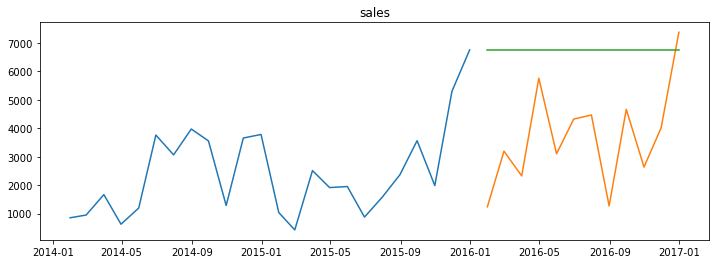

In [8]:
# Visualize the results.

plot_forecast('sales', superstore_train, superstore_validate, predictions)

### Simple Average

Now let's create a simple average forecast.

In [9]:
# Calculate the simple average.

simple_avg = round(superstore_train.sales.mean(), 2)
simple_avg

2443.89

In [10]:
# Create a predictions dataframe using the simple average.

predictions = make_static_predictions('sales', simple_avg, superstore_validate.index)
predictions.head()

,sales
order_date,
2016-01-31,2443.89
2016-02-29,2443.89
2016-03-31,2443.89
2016-04-30,2443.89
2016-05-31,2443.89


In [11]:
# Add the results to eval_df.

eval_df = append_eval_df('Simple Average', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,3509.0
1,Simple Average,sales,2127.0


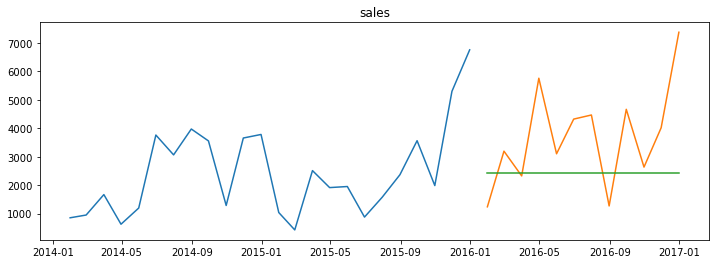

In [12]:
# Visualize the results.

plot_forecast('sales', superstore_train, superstore_validate, predictions)

### Moving Average

Now we'll create various moving average forecasts. We'll do the following moving averages: 1 month, 1 quarter, half year, and full year.

In [13]:
# For each period:
# - Calculate the moving average
# - Create the predictions dataframe
# - Add the results to eval_df
for period in periods:
    moving_avg = round(superstore_train.sales.rolling(period).mean()[-1], 2)
    predictions = make_static_predictions('sales', moving_avg, superstore_validate.index)
    eval_df = append_eval_df(f'Moving Average {period} Weeks', 'sales', superstore_validate, predictions, eval_df)
    
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,3509.0
1,Simple Average,sales,2127.0
2,Moving Average 1 Weeks,sales,3509.0
3,Moving Average 3 Weeks,sales,1979.0
4,Moving Average 6 Weeks,sales,1721.0
5,Moving Average 12 Weeks,sales,2081.0


### Results

For the overall total sales the simple average forecast provides the lowest RMSE value so this will be the baseline. We can determine this programmatically as well.

In [14]:
# Get the row with the minimum rmse value.

eval_df[eval_df.rmse == eval_df.rmse.min()]

,model_type,target,rmse
4,Moving Average 6 Weeks,sales,1721.0


### Throw it in a Function

Finally, let's create a function that can determine the best baseline for us.

In [15]:
# def establish_baseline(train, validate):
#     forecast_values = {
#         'Last Observed Value' : round(train.sales[-1], 2),
#         'Simple Average' : round(train.sales.mean(), 2)
#     }

#     periods = [4, 12, 26, 52]
#     for period in periods:
#         forecast_values[f'Moving Average {period} Weeks'] = round(train.sales.rolling(period).mean()[-1], 2)

#     predictions = {}
#     for key, value in forecast_values.items():
#         predictions[key] = make_static_predictions('sales', value, validate.index)

#     eval_df = None
#     for key, prediction in predictions.items():
#         eval_df = append_eval_df(key, 'sales', validate, prediction, eval_df)

#     return eval_df[eval_df.rmse == eval_df.rmse.min()]

In [16]:
# Let's test it

# establish_baseline(superstore_train, superstore_validate)

In [17]:
# Now let's test it from the model.py file.

eval_df = establish_baseline(superstore_train, superstore_validate, periods)
eval_df

,model_type,target,rmse
4,Moving Average 6 Weeks,sales,1721.0


---

## Creating Different Forecasting Models

Now that we have a baseline model we can try out some dynamic modeling strategies such as Holt's Linear Trend and FB Prophet.

### Holt's Linear Trend

Here we'll create a Holt model for forecasting sales.

In [18]:
# Create the model

model = Holt(superstore_train.sales, damped_trend = True)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [19]:
# Fit the model

model = model.fit()

In [20]:
# Make predictions

predictions = model.predict(
    start = superstore_validate.index[0],
    end = superstore_validate.index[-1]
)
predictions.head()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2016-01-31    6037.293158
2016-02-29    6238.041308
2016-03-31    6436.244686
2016-04-30    6631.935551
2016-05-31    6825.145752
Freq: M, dtype: float64

In [21]:
# Make predictions a dataframe

predictions = pd.DataFrame(predictions, columns = ['sales'], index = predictions.index)
predictions.head()

,sales
2016-01-31,6037.293158
2016-02-29,6238.041308
2016-03-31,6436.244686
2016-04-30,6631.935551
2016-05-31,6825.145752


In [22]:
eval_df = append_eval_df('Holt', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Moving Average 6 Weeks,sales,1721.0
1,Holt,sales,3725.0


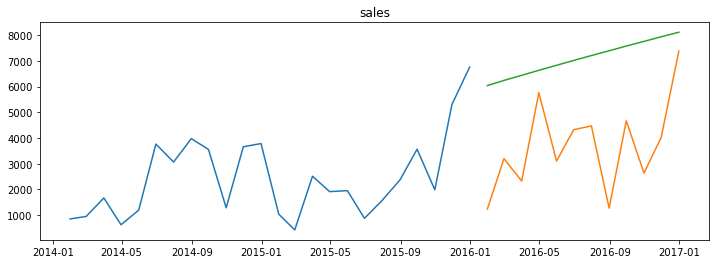

In [23]:
plot_forecast('sales', superstore_train, superstore_validate, predictions)

This model performs far worse than the baseline.

### FB Prophet

Now let's try a Prophet model.

In [24]:
# Create the model

model = Prophet()

In [25]:
# Fit the model

model.fit(pd.DataFrame({
    'ds' : superstore_train.index,
    'y' : superstore_train.sales
}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.


Initial log joint probability = 9.81923
Iteration  1. Log joint probability =    11.0159. Improved by 1.19663.
Iteration  2. Log joint probability =     22.774. Improved by 11.7581.
Iteration  3. Log joint probability =    23.8362. Improved by 1.06227.
Iteration  4. Log joint probability =     24.738. Improved by 0.901727.
Iteration  5. Log joint probability =    24.9185. Improved by 0.180513.
Iteration  6. Log joint probability =    25.1585. Improved by 0.24.
Iteration  7. Log joint probability =    25.1656. Improved by 0.00716836.
Iteration  8. Log joint probability =    25.2283. Improved by 0.0626667.
Iteration  9. Log joint probability =    25.2387. Improved by 0.010366.
Iteration 10. Log joint probability =     25.246. Improved by 0.00732951.
Iteration 11. Log joint probability =    25.2509. Improved by 0.00490465.
Iteration 12. Log joint probability =    25.2598. Improved by 0.00891596.
Iteration 13. Log joint probability =    25.2615. Improved by 0.00166215.
Iteration 14. Log jo

In [26]:
# Make predictions

future = model.make_future_dataframe(365)
results = model.predict(future)
predictions = results[['ds', 'yhat']].set_index('ds')
predictions.columns = ['sales']
predictions = predictions.resample(resample_period).mean()
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2014-01-31 to 2016-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


In [27]:
predictions.loc['2016'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2016-01-31 to 2016-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [28]:
eval_df = append_eval_df('Prophet', 'sales', superstore_validate, predictions.loc['2016'], eval_df)
eval_df

,model_type,target,rmse
0,Moving Average 6 Weeks,sales,1721.0
1,Holt,sales,3725.0
2,Prophet,sales,1636.0


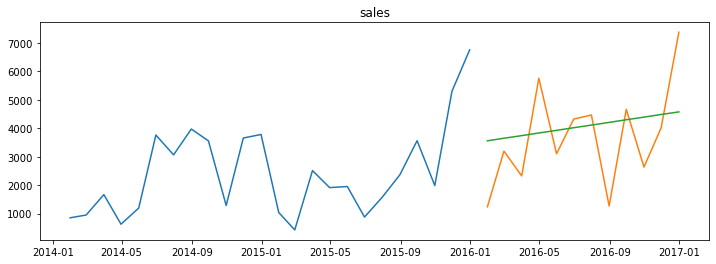

In [29]:
plot_forecast('sales', superstore_train, superstore_validate, predictions.loc['2016'])

Prophet also does not beat the baseline. We will likely need to narrow down the data by some category that will provide clearer insights into the sales trends. Without any seasonality in the data it's difficult to create an accurate model that does more than forecast average sales figures.

### Previous Cycle

Let's try one more strategy and use the previous cycle to predict the next one.

In [30]:
predictions = superstore_train.loc['2015'] + superstore_train.diff(year_size).mean()
predictions.index = superstore_validate.index

In [31]:
eval_df = append_eval_df('Previous Cycle', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Moving Average 6 Weeks,sales,1721.0
1,Holt,sales,3725.0
2,Prophet,sales,1636.0
3,Previous Cycle,sales,1933.0


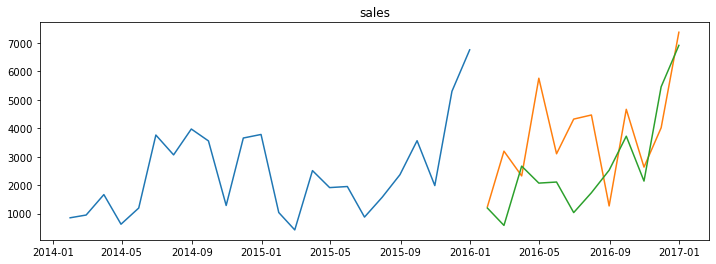

In [32]:
plot_forecast('sales', superstore_train, superstore_validate, predictions)

---

## Ensemble Model: A Model Per Region

In exploration we noticed that there is a little more seasonality when filtered by region. So here we will try to build an ensemble model where we have a sales forecast for each region and then combine the results to make a total sales forecast.

### Simple Average

Since the simple average provided the best results for the total sales model we'll create a simple average model here as well.

In [33]:
# Here we are using the model module to create an ensemble model for us.
# This will create simple average models for each region and then combine the results.

predictions = create_ensemble_predictions(
    [store_east_train, store_west_train, store_central_train, store_south_train],
    [store_east_validate, store_west_validate, store_central_validate, store_south_validate],
    'sales',
    simple_average_model
)
predictions.head()

,sales
order_date,
2016-01-31,2486.830106
2016-02-29,2486.830106
2016-03-31,2486.830106
2016-04-30,2486.830106
2016-05-31,2486.830106


In [34]:
region_eval_df = append_eval_df('Simple Average', 'sales', superstore_validate, predictions)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2102.0


### Holt's Linear Trend

Now let's try a Holt ensemble model.

In [35]:
# Here we are using the model module to create an ensemble model for us.
# This will create Holt's linear trend models for each region and then combine the results.

predictions = create_ensemble_predictions(
    [store_east_train, store_west_train, store_central_train, store_south_train],
    [store_east_validate, store_west_validate, store_central_validate, store_south_validate],
    'sales',
    holt_model
)
predictions.head()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,sales
2016-01-31,5215.905336
2016-02-29,5447.160293
2016-03-31,5675.748549
2016-04-30,5901.712327
2016-05-31,6125.091347


In [36]:
region_eval_df = append_eval_df('Holt', 'sales', superstore_validate, predictions, region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2102.0
1,Holt,sales,3136.0


### FB Prophet

Next, an ensemble model using Prophet.

In [37]:
# Here we are using the model module to create an ensemble model for us.
# This will create Prophet models for each region and then combine the results.

predictions = create_ensemble_predictions(
    [store_east_train, store_west_train, store_central_train, store_south_train],
    [store_east_validate, store_west_validate, store_central_validate, store_south_validate],
    'sales',
    prophet_model
)
predictions.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 9.29803
Iteration  1. Log joint probability =    12.9294. Improved by 3.6314.
Iteration  2. Log joint probability =    23.0799. Improved by 10.1504.
Iteration  3. Log joint probability =    23.3414. Improved by 0.261511.
Iteration  4. Log joint probability =    25.0426. Improved by 1.70126.
Iteration  5. Log joint probability =    25.4562. Improved by 0.413517.
Iteration  6. Log joint probability =    25.4577. Improved by 0.00158048.
Iteration  7. Log joint probability =    25.4993. Improved by 0.0415179.
Iteration  8. Log joint probability =    25.5087. Improved by 0.00943174.
Iteration  9. Log joint probability =    25.5094. Improved by 0.000689521.
Iteration 10. Log joint probability =    25.5132. Improved by 0.00384161.
Iteration 11. Log joint probability =    25.5144. Improved by 0.00122653.
Iteration 12. Log joint probability =     25.515. Improved by 0.00055842.
Iteration 13. Log joint probability =    25.5155. Improved by 0.000495173.
Iteration 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 17.



Initial log joint probability = 8.7241
Iteration  1. Log joint probability =    10.9867. Improved by 2.26265.
Iteration  2. Log joint probability =     12.203. Improved by 1.21621.
Iteration  3. Log joint probability =    17.4359. Improved by 5.23291.
Iteration  4. Log joint probability =    17.5711. Improved by 0.135189.
Iteration  5. Log joint probability =    18.0257. Improved by 0.454603.
Iteration  6. Log joint probability =    18.1169. Improved by 0.0912736.
Iteration  7. Log joint probability =     18.132. Improved by 0.0150568.
Iteration  8. Log joint probability =    18.1379. Improved by 0.00587661.
Iteration  9. Log joint probability =    18.1417. Improved by 0.00381383.
Iteration 10. Log joint probability =    18.1482. Improved by 0.00648255.
Iteration 11. Log joint probability =     18.152. Improved by 0.00386419.
Iteration 12. Log joint probability =    18.1548. Improved by 0.00279946.
Iteration 13. Log joint probability =    18.1567. Improved by 0.0019193.
Iteration 14. 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 10.3071
Iteration  1. Log joint probability =    17.0204. Improved by 6.71337.
Iteration  2. Log joint probability =    20.0661. Improved by 3.04569.
Iteration  3. Log joint probability =    20.1439. Improved by 0.0777411.
Iteration  4. Log joint probability =    20.1884. Improved by 0.0445134.
Iteration  5. Log joint probability =    20.2702. Improved by 0.081837.
Iteration  6. Log joint probability =    20.2735. Improved by 0.00323318.
Iteration  7. Log joint probability =    20.2807. Improved by 0.00724572.
Iteration  8. Log joint probability =    20.2964. Improved by 0.0157024.
Iteration  9. Log joint probability =     20.299. Improved by 0.00263414.
Iteration 10. Log joint probability =    20.3018. Improved by 0.00271831.
Iteration 11. Log joint probability =    20.3037. Improved by 0.00190525.
Iteration 12. Log joint probability =    20.3039. Improved by 0.000224665.
Iteration 13. Log joint probability =    20.3047. Improved by 0.000855943.
Iterat

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 8.86229
Iteration  1. Log joint probability =    10.7681. Improved by 1.90578.
Iteration  2. Log joint probability =     15.081. Improved by 4.31291.
Iteration  3. Log joint probability =    19.5181. Improved by 4.43717.
Iteration  4. Log joint probability =    21.4053. Improved by 1.88714.
Iteration  5. Log joint probability =    21.5029. Improved by 0.0976461.
Iteration  6. Log joint probability =    21.5342. Improved by 0.0312274.
Iteration  7. Log joint probability =    21.5458. Improved by 0.0116168.
Iteration  8. Log joint probability =    21.5474. Improved by 0.00158799.
Iteration  9. Log joint probability =    21.5828. Improved by 0.035426.
Iteration 10. Log joint probability =    21.6408. Improved by 0.0579958.
Iteration 11. Log joint probability =    21.8336. Improved by 0.192774.
Iteration 12. Log joint probability =    21.8508. Improved by 0.0172666.
Iteration 13. Log joint probability =     21.891. Improved by 0.0402217.
Iteration 14. Log j

,sales
ds,
2014-01-31,NaN
2014-02-28,1589.412182
2014-03-31,1675.306194
2014-04-30,1758.429432
2014-05-31,1844.323445


In [38]:
region_eval_df = append_eval_df('Prophet', 'sales', superstore_validate, predictions.loc['2016'], region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2102.0
1,Holt,sales,3136.0
2,Prophet,sales,1623.0


### Previous Cycle

Finally, let's do an ensemble previous cycle model.

In [39]:
# Here we are using the model module to create an ensemble model for us.
# This will create previous cycle models for each region and then combine the results.

predictions = create_ensemble_predictions(
    [store_east_train, store_west_train, store_central_train, store_south_train],
    [store_east_validate, store_west_validate, store_central_validate, store_south_validate],
    'sales',
    previous_cycle_model
)
predictions.head()

,sales,quantity,discount,profit
order_date,,,,
2016-01-31,1170.122731,38.060606,2.704924,-521.42069
2016-02-29,558.478731,36.060606,1.604924,65.66441
2016-03-31,2644.688731,77.060606,4.204924,227.68831
2016-04-30,2046.982731,82.060606,4.604924,66.29431
2016-05-31,2084.691731,119.060606,6.104924,399.68321


In [40]:
region_eval_df = append_eval_df('Previous Cycle', 'sales', superstore_validate, predictions, region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2102.0
1,Holt,sales,3136.0
2,Prophet,sales,1623.0
3,Previous Cycle,sales,1946.0


### Results

We still get the most accurate forecast from the simple average model. I wonder if we may get a more accurate forecast by resampling by month or quarter instead.

---

## Ensemble Model: A Model Per Product Category

The last modeling strategy we'll try is building ensemble models separating by category.

### Simple Average

First the simple average model.

In [41]:
# Here we are using the model module to create an ensemble model for us.
# This will create simple average models for each product category and then combine the results.

predictions = create_ensemble_predictions(
    [office_supplies_train, furniture_train, technology_train],
    [office_supplies_validate, furniture_validate, technology_validate],
    'sales',
    simple_average_model
)
predictions.head()

,sales
order_date,
2016-01-31,2443.891083
2016-02-29,2443.891083
2016-03-31,2443.891083
2016-04-30,2443.891083
2016-05-31,2443.891083


In [42]:
region_eval_df = append_eval_df('Simple Average', 'sales', superstore_validate, predictions)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2127.0


### Holt's Linear Trend

Next, an ensemble Holt's linear trend model.

In [43]:
# Here we are using the model module to create an ensemble model for us.
# This will create Holt's linear trend models for each product category and then combine the results.

predictions = create_ensemble_predictions(
    [office_supplies_train, furniture_train, technology_train],
    [office_supplies_validate, furniture_validate, technology_validate],
    'sales',
    holt_model
)
predictions.head()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,sales
2016-01-31,5884.958233
2016-02-29,6415.490247
2016-03-31,6939.195054
2016-04-30,7456.245423
2016-05-31,7966.805796


In [44]:
region_eval_df = append_eval_df('Holt', 'sales', superstore_validate, predictions, region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2127.0
1,Holt,sales,5293.0


### FB Prophet

Next, an ensemble Prophet model.

In [45]:
# Here we are using the model module to create an ensemble model for us.
# This will create Prophet models for each product category and then combine the results.

predictions = create_ensemble_predictions(
    [office_supplies_train, furniture_train, technology_train],
    [office_supplies_validate, furniture_validate, technology_validate],
    'sales',
    prophet_model
)
predictions.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 9.48139
Iteration  1. Log joint probability =    5.52878. Improved by -3.9526.
Iteration  2. Log joint probability =      8.256. Improved by 2.72722.
Iteration  3. Log joint probability =    15.0646. Improved by 6.80858.
Iteration  4. Log joint probability =    15.1031. Improved by 0.0385607.
Iteration  5. Log joint probability =    15.1936. Improved by 0.0904729.
Iteration  6. Log joint probability =    21.0434. Improved by 5.84981.
Iteration  7. Log joint probability =    21.1259. Improved by 0.0825094.
Iteration  8. Log joint probability =    21.2825. Improved by 0.156566.
Iteration  9. Log joint probability =    21.5077. Improved by 0.225225.
Iteration 10. Log joint probability =    21.5525. Improved by 0.0447685.
Iteration 11. Log joint probability =    21.6129. Improved by 0.0604164.
Iteration 12. Log joint probability =    21.8856. Improved by 0.272731.
Iteration 13. Log joint probability =    22.1527. Improved by 0.26706.
Iteration 14. Log joint

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 10.355
Iteration  1. Log joint probability =    11.0121. Improved by 0.657152.
Iteration  2. Log joint probability =    20.0808. Improved by 9.06872.
Iteration  3. Log joint probability =    22.2488. Improved by 2.16798.
Iteration  4. Log joint probability =    22.5738. Improved by 0.325031.
Iteration  5. Log joint probability =    22.8151. Improved by 0.241244.
Iteration  6. Log joint probability =    22.8719. Improved by 0.0567755.
Iteration  7. Log joint probability =    22.9655. Improved by 0.0936795.
Iteration  8. Log joint probability =    22.9675. Improved by 0.00197847.
Iteration  9. Log joint probability =    23.0178. Improved by 0.0502662.
Iteration 10. Log joint probability =    23.0584. Improved by 0.0405977.
Iteration 11. Log joint probability =     23.076. Improved by 0.0176479.
Iteration 12. Log joint probability =    23.0859. Improved by 0.00983138.
Iteration 13. Log joint probability =    23.0894. Improved by 0.00354606.
Iteration 14. L

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 9.3333
Iteration  1. Log joint probability =    7.74664. Improved by -1.58666.
Iteration  2. Log joint probability =    17.7482. Improved by 10.0015.
Iteration  3. Log joint probability =    19.0838. Improved by 1.33566.
Iteration  4. Log joint probability =    19.5868. Improved by 0.502905.
Iteration  5. Log joint probability =    19.6181. Improved by 0.0313452.
Iteration  6. Log joint probability =    19.6366. Improved by 0.0185219.
Iteration  7. Log joint probability =    19.6422. Improved by 0.00558896.
Iteration  8. Log joint probability =     19.677. Improved by 0.0348235.
Iteration  9. Log joint probability =    19.6944. Improved by 0.0173931.
Iteration 10. Log joint probability =    19.7052. Improved by 0.0107414.
Iteration 11. Log joint probability =    19.7339. Improved by 0.0287127.
Iteration 12. Log joint probability =    19.8086. Improved by 0.0747069.
Iteration 13. Log joint probability =    19.8229. Improved by 0.0143533.
Iteration 14. Lo

,sales
ds,
2014-01-31,1385.845992
2014-02-28,1470.734973
2014-03-31,1564.719202
2014-04-30,1655.671682
2014-05-31,1749.655911


In [46]:
region_eval_df = append_eval_df('Prophet', 'sales', superstore_validate, predictions.loc['2016'], region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2127.0
1,Holt,sales,5293.0
2,Prophet,sales,1635.0


### Previous Cycle

Lastly, an ensemble previous cycle model.

In [47]:
# Here we are using the model module to create an ensemble model for us.
# This will create previous cycle models for each product category and then combine the results.

predictions = create_ensemble_predictions(
    [office_supplies_train, furniture_train, technology_train],
    [office_supplies_validate, furniture_validate, technology_validate],
    'sales',
    previous_cycle_model
)
predictions.head()

,sales,quantity,discount,profit
order_date,,,,
2016-01-31,1195.52425,38.166667,2.7,-520.466808
2016-02-29,583.88025,36.166667,1.6,66.618292
2016-03-31,2670.09025,77.166667,4.2,228.642192
2016-04-30,2072.38425,82.166667,4.6,67.248192
2016-05-31,2110.09325,119.166667,6.1,400.637092


In [48]:
region_eval_df = append_eval_df('Previous Cycle', 'sales', superstore_validate, predictions, region_eval_df)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2127.0
1,Holt,sales,5293.0
2,Prophet,sales,1635.0
3,Previous Cycle,sales,1933.0


### Results

It looks like the results are the same across the board whether we split by region, category, or forecast total sales.

## Conclusion

Not all the markdown and comments are going to match the code results. Many iterations of the models were executed. Some with resamples of weeks, months, and quarters, others with the same resamplings but outliers removed.

The model that had the most accurate forecast was the Prophet model and the difference between the total sales forecast and ensemble models wasn't significant.

Below we'll produce the forecast for 2018 using Prophet.

In [52]:
predictions = prophet_model('sales', superstore_train, None, period = 365 * 3)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 9.81923
Iteration  1. Log joint probability =    11.0159. Improved by 1.19663.
Iteration  2. Log joint probability =     22.774. Improved by 11.7581.
Iteration  3. Log joint probability =    23.8362. Improved by 1.06227.
Iteration  4. Log joint probability =     24.738. Improved by 0.901727.
Iteration  5. Log joint probability =    24.9185. Improved by 0.180513.
Iteration  6. Log joint probability =    25.1585. Improved by 0.24.
Iteration  7. Log joint probability =    25.1656. Improved by 0.00716836.
Iteration  8. Log joint probability =    25.2283. Improved by 0.0626667.
Iteration  9. Log joint probability =    25.2387. Improved by 0.010366.
Iteration 10. Log joint probability =     25.246. Improved by 0.00732951.
Iteration 11. Log joint probability =    25.2509. Improved by 0.00490465.
Iteration 12. Log joint probability =    25.2598. Improved by 0.00891596.
Iteration 13. Log joint probability =    25.2615. Improved by 0.00166215.
Iteration 14. Log j

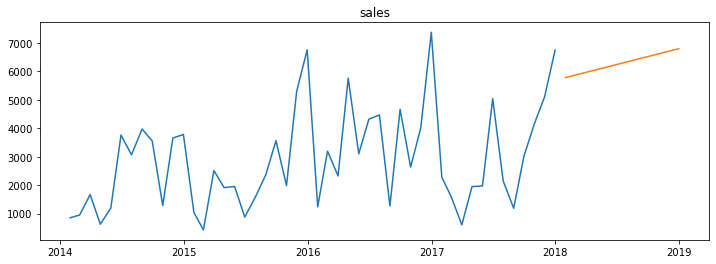

In [54]:
plot_forecast('sales', superstore.resample('M').sum(), predictions.loc['2018'])

This model had an error of 1636 on unseen data.

In [55]:
predictions = prophet_model('profit', superstore_train, None, period = 365 * 3)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.



Initial log joint probability = 9.38263
Iteration  1. Log joint probability =    9.84176. Improved by 0.459132.
Iteration  2. Log joint probability =    10.4928. Improved by 0.65107.
Iteration  3. Log joint probability =    10.6146. Improved by 0.121807.
Iteration  4. Log joint probability =    10.6338. Improved by 0.0191752.
Iteration  5. Log joint probability =    10.9743. Improved by 0.340485.
Iteration  6. Log joint probability =    10.9886. Improved by 0.0143064.
Iteration  7. Log joint probability =    10.9989. Improved by 0.0102536.
Iteration  8. Log joint probability =    11.0101. Improved by 0.0112045.
Iteration  9. Log joint probability =     11.012. Improved by 0.00190564.
Iteration 10. Log joint probability =    11.0162. Improved by 0.00426566.
Iteration 11. Log joint probability =    11.0185. Improved by 0.00222003.
Iteration 12. Log joint probability =    11.0193. Improved by 0.00086403.
Iteration 13. Log joint probability =    11.0214. Improved by 0.00205317.
Iteration 

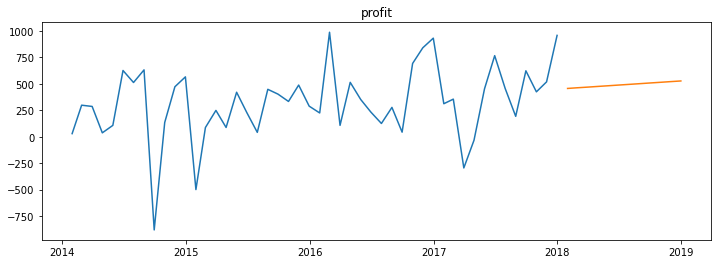

In [56]:
plot_forecast('profit', superstore.resample('M').sum(), predictions.loc['2018'])

The forecast for profit is also growth in 2018.